In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used

import sys
import attr
import functools
import tqdm
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../src')

from dataset import DatasetConfig, DatasetBuilder
from geometry import Rays
import os
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from collections import defaultdict
from typing import Callable, Dict, List, Tuple

import nerf
from nerf import NerfConfig, Nerf
import nerf_utils
import jax.numpy as jnp

import jax
from jax import jit, random
from trainer import Trainer, TrainerConfig
from flax import jax_utils
from IPython.display import display, clear_output

%matplotlib inline

plt.rcParams["figure.figsize"] = (10, 10)

In [11]:
ds_config =  DatasetConfig(model_dir='../dataset/pinecone/sparse/0/',
                           images_dir='../dataset/pinecone/images_8/',
                           batch_from_single_image=True,
                           train_batch_size=2048,
                           test_batch_size=-1)
trainer_config = TrainerConfig(dataset_config=ds_config)
trainer = Trainer(trainer_config)
train_iter, eval_iter = trainer.create_dataset()

In [16]:
eval_rays = next(eval_iter)

def render():
    counts = [4096] * 42 + [3660]
    index = np.cumsum([0] + counts)[:-1]

    config = nerf.NerfConfig()
    config.coarse_module_config.mlp_config.noise_std = 0.0
    model = nerf.Nerf(config)

    colors_list = []
    # eval_rays = next(eval_iter)
    for i, c in zip(index, counts):
        cur_rays = jax.tree_map(lambda x: x[0, i:i + c, :], eval_rays)
        colors, _ = model.apply(state.optimizer.target, rng, cur_rays)
        colors_list.append(colors)

    colors = jnp.concatenate(colors_list, axis=0)
    return colors.reshape((-1, 484, 3))

In [15]:
import optax
import flax
from flax.training import train_state
import trainer_utils
from typing import Any, Callable

from flax import core
from flax import struct
from jax import lax, jit, random

rays = next(train_iter)

@flax.struct.dataclass
class TrainState:
    apply_fn: Callable = struct.field(pytree_node=False)
    optimizer: flax.optim.Optimizer

def create_train_state():
    rng = random.PRNGKey(20200823)
    key0, key1 = random.split(rng)
    model = nerf.Nerf(nerf.NerfConfig())
    params = model.init(key0, key1, jax.tree_map(lambda x:x[0], rays))
    optimizer = flax.optim.Adam(5e-4).create(params)
    state = TrainState(
        apply_fn=model.apply,
        optimizer=optimizer)
    return state

@jax.jit
def train_step(rng, state, rays):
    """Perform a single training step."""
    rng, key = random.split(rng)

    def loss_fn(params):
        coarse_pred, fine_pred = state.apply_fn(params, key, rays)
        loss = jnp.square(coarse_pred - rays.colors).mean()
        loss = loss + jnp.square(fine_pred - rays.colors).mean()
        return loss

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.optimizer.target)
    new_optimizer = state.optimizer.apply_gradient(grads, learning_rate=5e-4)
    new_state = state.replace(optimizer=new_optimizer)
    return new_state, loss, grads

state = create_train_state()
rng = random.PRNGKey(1122546)

In [17]:
losses = []

for step, rays in zip(range(int(5e6)), train_iter):
    key, rng = random.split(rng)
    state, loss, grads = train_step(key, state, jax.tree_map(lambda x:x[0], rays))
    if jnp.isnan(loss):
        break
    losses.append(loss)
    if step % 5000 == 0:
        eval_img = render()
        plt.imshow(eval_img)
        plt.show()
        clear_output(wait = True)

KeyboardInterrupt: 

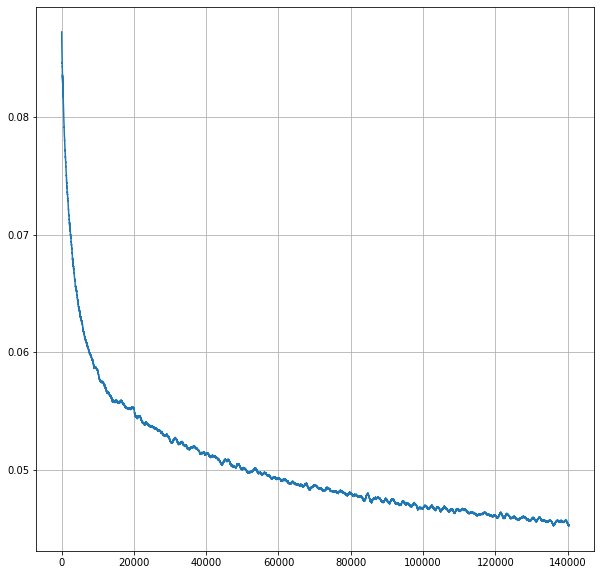

In [18]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

plt.plot(moving_average(losses, 1000))
plt.grid('on')

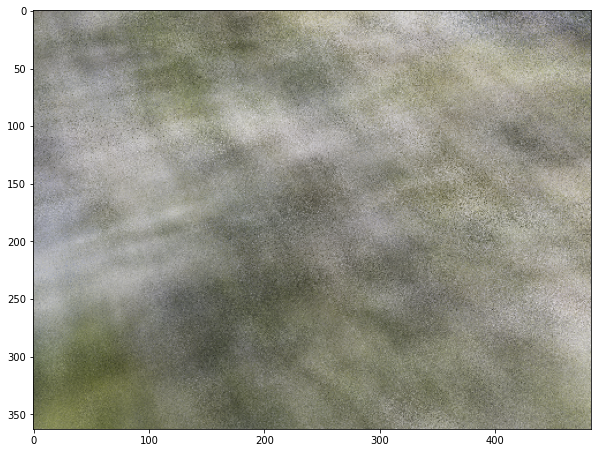

In [22]:
eval_rays = next(eval_iter)

eval_img = render()
plt.imshow(eval_img)

In [40]:
from flax.training import checkpoints

def restore_checkpoint(state, workdir):
    return checkpoints.restore_checkpoint(workdir, state)

def save_checkpoint(state, workdir):
    # get train state from the first replica
    state = jax.device_get(state)
    step = 1000
    checkpoints.save_checkpoint(workdir, state, step, keep=3)

save_checkpoint(state, "../models/")

In [15]:
loss

DeviceArray(0.02295545, dtype=float32)

In [53]:
state = restore_checkpoint(state, "./checkpoint_100000")

counts = [2048] * 5953 + [1024]
index = np.cumsum([0] + counts)[:-1]

coarse_colors_list = []
fine_colors_list = []

eval_rays = next(eval_iter)
for i, c in zip(index, counts):
    cur_rays = jax.tree_map(lambda x: x[0, i:i + c, :], eval_rays)
    coarse_colors, fine_colors = state.apply_fn(state.params, trainer._rng, cur_rays)
    coarse_colors_list.append(coarse_colors)
    fine_colors_list.append(fine_colors)

In [55]:
colors.shape

(12192768, 3)

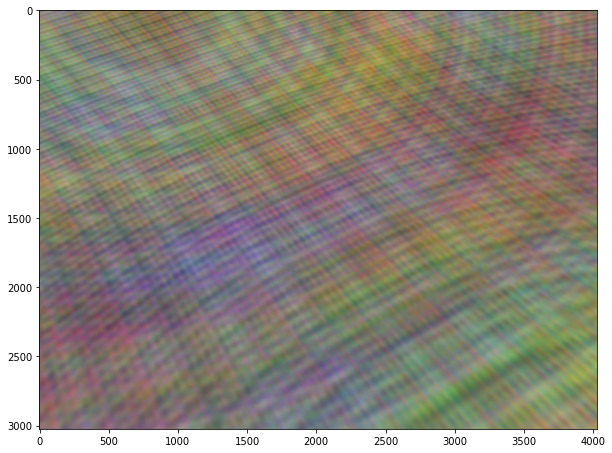

In [60]:
colors = jnp.concatenate(fine_colors_list, axis=0)
image = colors.reshape((-1, 4032, 3))
plt.imshow(image)

In [28]:
#state = jax_utils.unreplicate(states)
eval_rays = next(eval_iter)
_, fine_colors = state.apply_fn(state.params, trainer._rng, jax.tree_map(lambda x: x[0, :2048, :], eval_rays))

# image = fine_colors.reshape((-1, 4032, 3))
# plt.imshow(image)

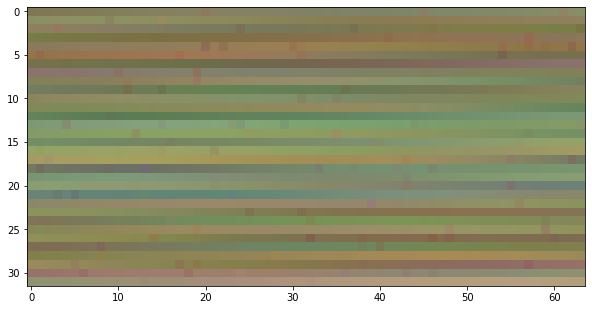

In [44]:
plt.imshow(fine_colors.reshape((-1, 64, 3)))

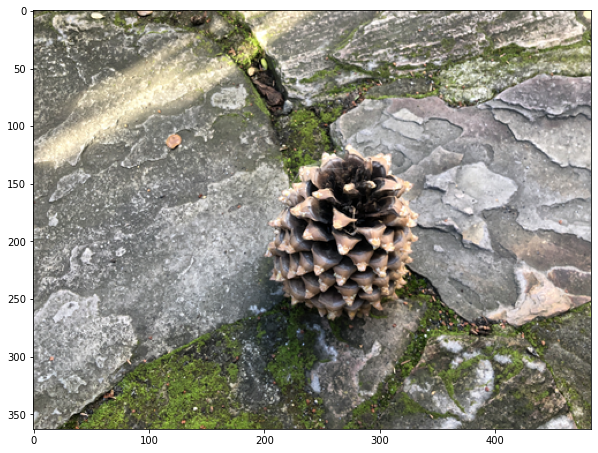

In [21]:
colors = np.copy(eval_rays.colors[0])
# colors[:2048, ...] = 0 #fine_colors

image = colors.reshape((-1, 484, 3))
plt.imshow(image)

In [30]:
fine_colors.shape

(2048, 3)

In [ ]:
rays = next(train_iter)

In [ ]:
state = trainer.create_train_state()

In [ ]:
p_train_step = jax.pmap(
    functools.partial(trainer.train_step, learning_rate_fn=None),
    axis_name='batch')

In [ ]:
keys = random.split(trainer._rng, 1)
states = jax_utils.replicate(state)
new_state, metrics = p_train_step(keys, states, rays)

In [ ]:
coarse_rgb, fine_rgb = state.apply_fn(state.params, trainer._rng, jax.tree_map(lambda x: x[0], rays))

In [ ]:
plt.imshow(coarse_rgb.reshape((64, -1)))

In [ ]:
@attr.s(frozen=True, auto_attribs=True)
class NerfBuilder:
    config: NerfConfig

    def build(self, rng: jnp.ndarray, rays: Rays):
        model = Nerf(self.config)
        key1, key2, rng = random.split(rng, num=3)
        init_params = model.init(
            key1, rng=key2, rays=rays)
        return model, init_params

rng = random.PRNGKey(0)
rays_local = jax.tree_map(lambda x:x[0], rays)
model, init_params = NerfBuilder(NerfConfig()).build(rng, rays_local)
coarse_rgb, fine_rgb = model.apply(init_params, rng, rays_local)

In [ ]:
import ml_collections

In [ ]:
@attr.s(frozen=True, auto_attribs=True)
class Foo:
    a: int = 0
    b: int = 1

In [ ]:
foo = Foo()
asdict(foo)

In [ ]:
from attr import asdict

In [ ]:
cfg = ml_collections.ConfigDict()
cfg.float_field = 12.6
cfg.integer_field = 123
cfg.another_integer_field = 234
cfg.nested = ml_collections.ConfigDict()
cfg.nested.string_field = 'tom'

print(cfg.integer_field)  # Prints 123.
print(cfg['integer_field'])  # Prints 123 as well.

In [ ]:
cfg

In [ ]:
coarse_rgb

In [ ]:
EPS = 1e-10

def volumetric_rendering(points_rgb, points_sigma, points_z, dirs, white_bkgd=True):
    dists = points_z[..., 1:] - points_z[..., :-1]
    dists = jnp.concatenate([dists, 1e10 * jnp.ones_like(dists[..., :1])], axis=-1)
    dists = dists * jnp.linalg.norm(dirs, axis=-1, keepdims=True)

    dists_sigma = points_sigma[..., 0] * dists
    alpha = 1.0 - jnp.exp(-dists_sigma)

    transmit = jnp.exp(-jnp.cumsum(dists_sigma[:, :-1], axis=-1))
    transmit = jnp.concatenate([jnp.ones_like(transmit[:, :1]), transmit], axis=-1)
    weights = alpha * transmit
    
    rgb = jnp.sum(weights[..., jnp.newaxis] * points_rgb, axis=1)
    depth = jnp.sum(weights * points_z, axis=1, keepdims=True)
    
    acc = jnp.sum(weights, axis=-1, keepdims=True)
    disp = acc / (depth + EPS)
    if white_bkgd:
        rgb = rgb + (1. - acc)
    return rgb, disp, acc, weights

points_rgb = random.uniform(rng, (64, 100, 3)) / 1000
points_sigma = random.uniform(rng, (64, 100, 1)) / 1000
rgb, disp, acc, weights = nerf_utils.volumetric_rendering(points_rgb, points_sigma, points_z, rays.directions)

In [ ]:
rgb

In [ ]:
import functools

from flax import jax_utils

num_rays = rays.origins.shape[0]
num_bins = 100
bins = jnp.linspace(0.001, 1000, num_bins)
bins = jnp.broadcast_to(bins, (num_rays, num_bins))
weights = jnp.ones_like(bins)
# sampler_fn = jit(functools.partial(nerf_utils.sample_along_rays,
#                                    100,
#                                    randomized=True))
sampler_fn = functools.partial(nerf_utils.sample_along_rays,
                               num_samples=100,
                               randomized=True)
points, points_z = sampler_fn(rng, rays, bins, weights)
encode = nerf_utils.positional_encoding(points, 0, 10)

encode.shape

In [ ]:
points_z.shape

In [ ]:
encode = nerf_utils.positional_encoding(rays.directions[:, jnp.newaxis, :], 0, 10)

encode.shape

In [ ]:
rays.directions.shape